In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import gensim
#from gsdmm import MovieGroupProcess
from gensim.models import CoherenceModel
#from utils import create_logger
import json
#from NLP_preprocess import AidesDataset
import gensim.corpora as corpora
import os
import argparse
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import pickle
import math
from wordcloud import WordCloud
# DEBUG
from pdb import set_trace as bp

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
!pip install git+https://github.com/rwalk/gsdmm.git

  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-91f7sqpe
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-91f7sqpe
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4603 sha256=17b5d4861e5097838d77aa021f1f143481c5b79cc3af2cc4a58af57fecb381b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-5g4_yxpw/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [5]:
from gsdmm import MovieGroupProcess

In [6]:
cd src/

/content/src


In [10]:
from utils import create_logger
from aides_dataset import AidesDataset

In [8]:
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.probability import FreqDist

In [11]:
cd ..

/content


In [12]:
cd data/

/content/data


number of aides: 439
In stage 0: transferred 288 clusters with 15 clusters populated
In stage 1: transferred 94 clusters with 9 clusters populated
In stage 2: transferred 12 clusters with 8 clusters populated
In stage 3: transferred 4 clusters with 8 clusters populated
In stage 4: transferred 3 clusters with 8 clusters populated
In stage 5: transferred 2 clusters with 8 clusters populated
In stage 6: transferred 1 clusters with 8 clusters populated
In stage 7: transferred 3 clusters with 8 clusters populated
In stage 8: transferred 1 clusters with 8 clusters populated
In stage 9: transferred 1 clusters with 8 clusters populated
In stage 10: transferred 7 clusters with 8 clusters populated
In stage 11: transferred 3 clusters with 8 clusters populated
In stage 12: transferred 1 clusters with 8 clusters populated
In stage 13: transferred 2 clusters with 8 clusters populated
In stage 14: transferred 2 clusters with 8 clusters populated
Number of documents per topic : [ 14   0  20   0   4  

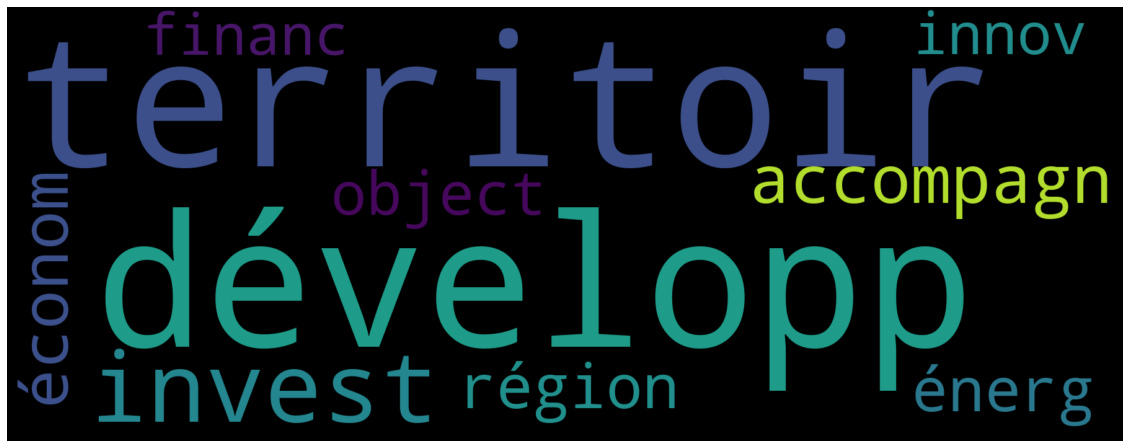

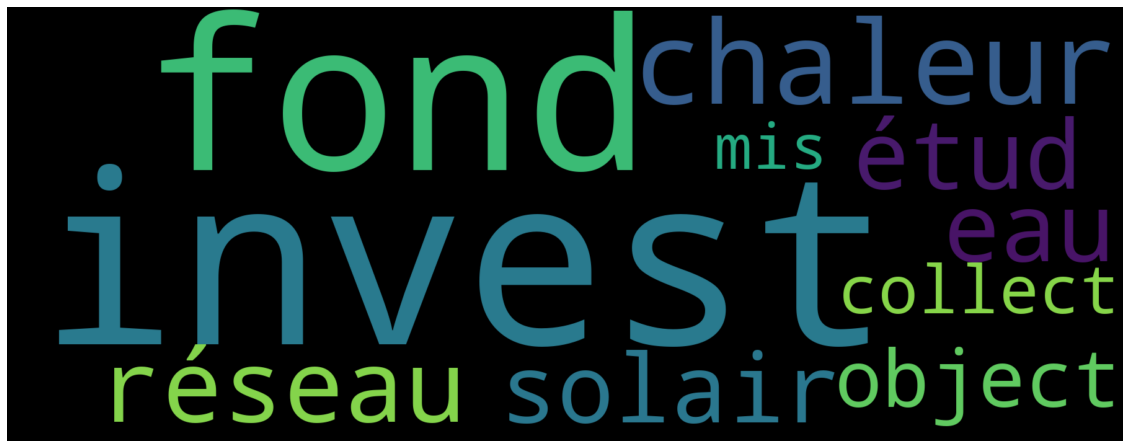

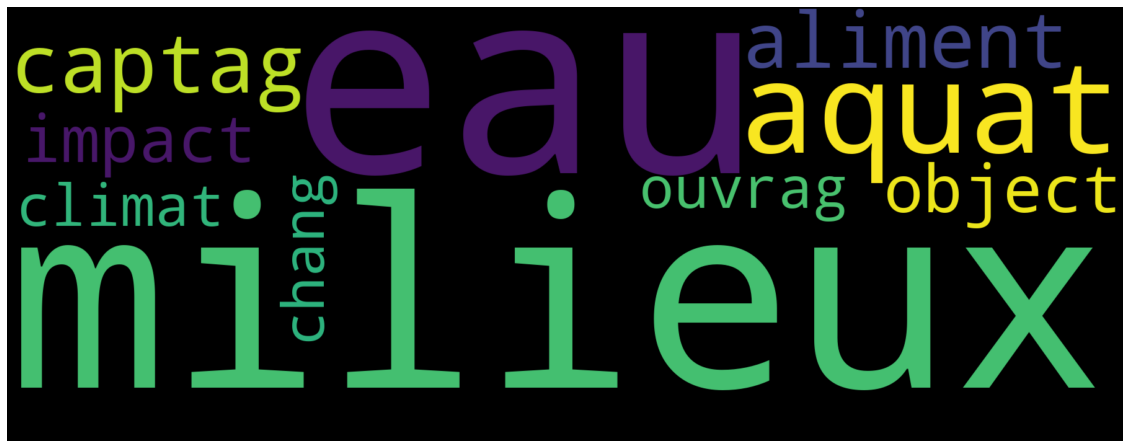

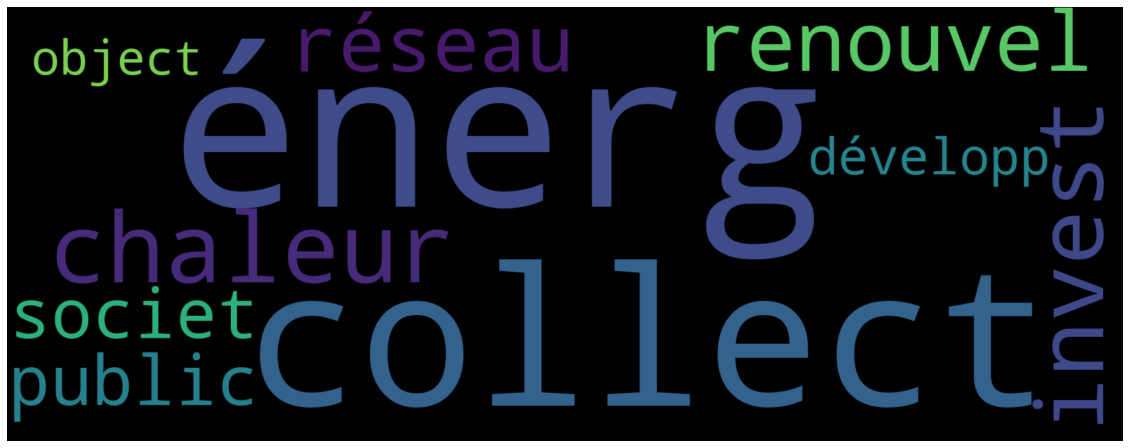

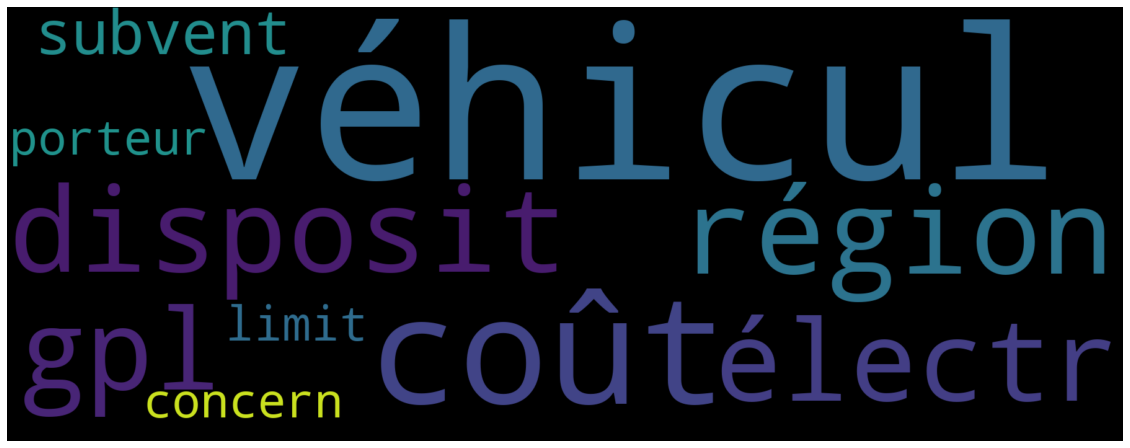

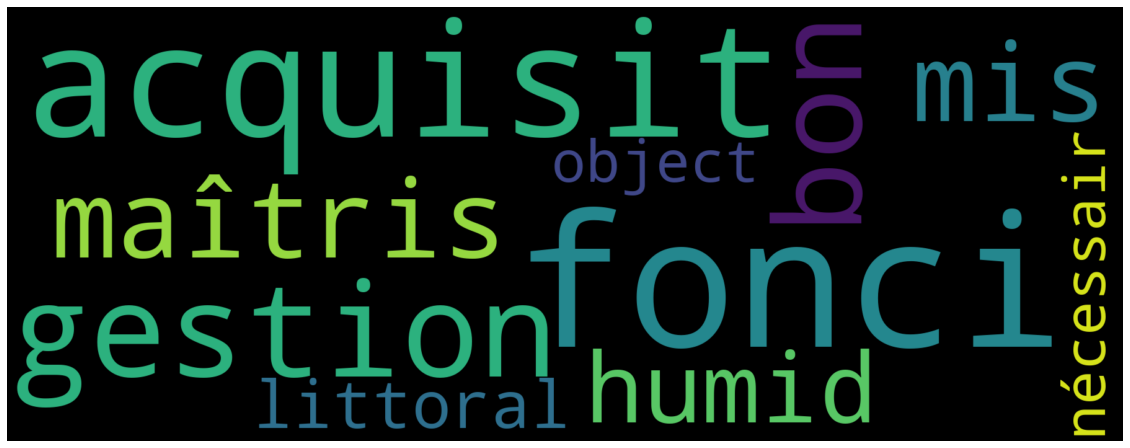

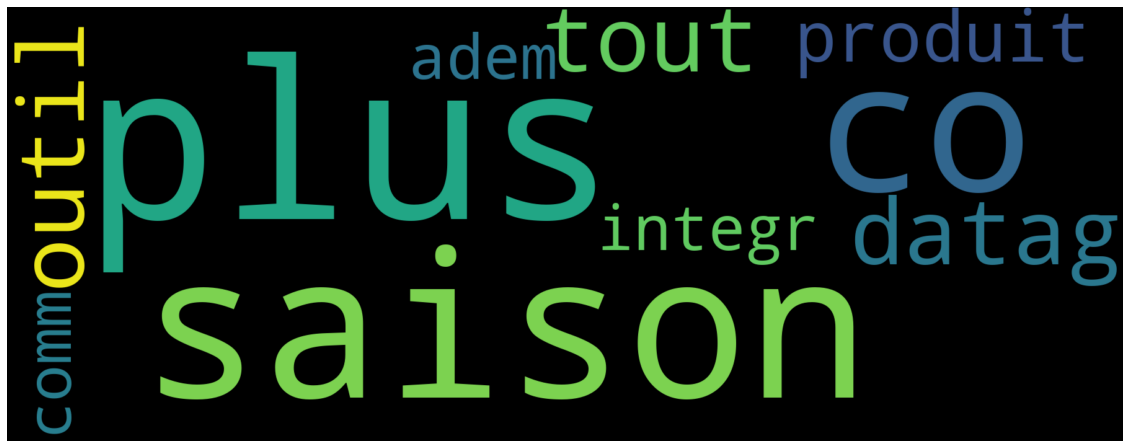

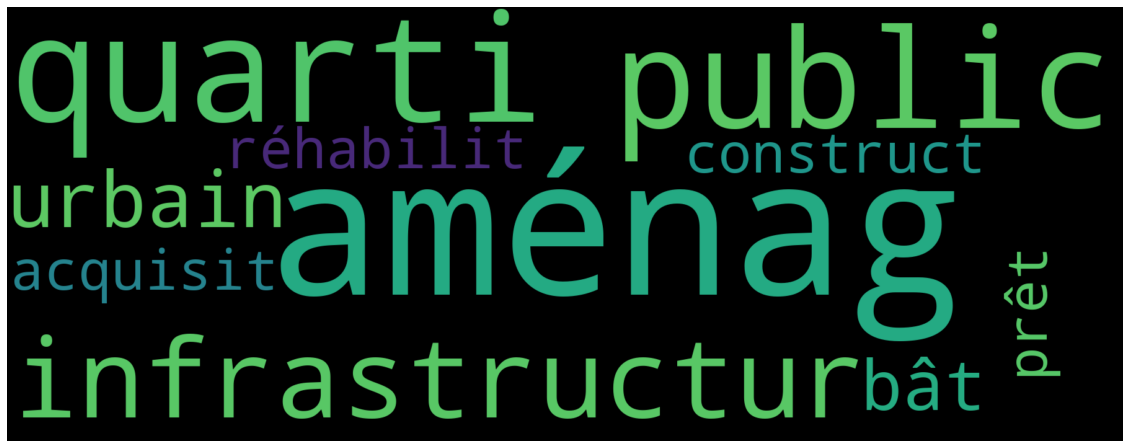

In [14]:
def number_docs(model):
    # print number of documents per topic
    doc_count = np.array(model.cluster_doc_count)
    print('Number of documents per topic :', doc_count)

    # Topics sorted by the number of document they are allocated to
    top_index = doc_count.argsort()[-8:][::-1]
    print('Most important clusters (by number of docs inside):', top_index)
    return top_index

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))


def display_wordcloud(nb_topic, cluster_word_distribution):
    # Select topic you want to output as dictionary (using topic_number)
    wordcloud = WordCloud(width=1800, height=700, max_words = 10).generate_from_frequencies(cluster_word_distribution[nb_topic])

    # Print to screen
    fig, ax = plt.subplots(figsize=[20,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # Save to disk
    wordcloud.to_file("cluster"+str(nb_topic)+".png")


# define function to get words in topics
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.
    
    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include
    
    '''
    # create empty list to contain topics
    topics = []
    
    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        #create empty list to contain words
        topic = []
        
        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)
            
        #append topics to topics list    
        topics.append(topic)
    
    return topics

def coherence_gsdmm(model, top_index, id2word, corpus, texts):
    # get topics to feed to coherence model
    topics = get_topics_lists(model, top_index, 5) 

    # evaluate model using Topic Coherence score
    cm_gsdmm = CoherenceModel(topics=topics, 
                            dictionary=id2word, 
                            corpus=corpus, 
                            texts=texts, 
                            coherence='u_mass')

    # get coherence value
    coherence_gsdmm = cm_gsdmm.get_coherence()  

    print(coherence_gsdmm)


#Creation dataset
"""
aides_dataset = AidesDataset("AT_aides_full.json")
processed_data = aides_dataset.get_data_words()
data_train, data_test = train_test_split(processed_data, test_size=100)
train_data_words = data_train.values.flatten()
id2word = corpora.Dictionary(train_data_words)
"""

# Create Corpus
#train_corpus = [id2word.doc2bow(feature_words) for feature_words in train_data_words]

def get_corpus():
  """get the corpus given the bag-of-words for each description"""
  #aides_dataset = AidesDataset("AT_aides_full.json")
  aides_dataset = AidesDataset("MT_aides.json")
  processed_data = aides_dataset.get_data_words()
  data_train, data_test = train_test_split(processed_data, test_size=100)
  data_words = processed_data.values.flatten()
  train_data_words = data_train.values.flatten()
  test_data_words = data_test.values.flatten()
  id2word = corpora.Dictionary(data_words)  # the vocabulary is built upon all data
  # Create train Corpus & test corpus
  train_corpus = [id2word.doc2bow(feature_words) for feature_words in train_data_words]
  test_corpus = [id2word.doc2bow(feature_words) for feature_words in test_data_words]
  train_corpus = train_corpus
  test_corpus = test_corpus
  train_data = train_data_words
  test_data = test_data_words
  id2word = id2word
  # if self.out_path is not None:
  # vocab_out_path = os.path.join(self.out_path, "id2word.json")
  # with open(vocab_out_path, 'w') as f:
  #     json.dump(dict(id2word), f, ensure_ascii=False)
  return train_data_words, test_data_words, id2word, train_corpus

# initialize GSDMM
train_data_words, test_data_words, id2word, train_corpus = get_corpus()
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=15)

# fit GSDMM model
gsdmm.fit(train_data_words, len(id2word))

# get top words in topics
# Get topic word distributions from gsdmm model
cluster_word_distribution = gsdmm.cluster_word_distribution
top_index = number_docs(gsdmm)
top_words(cluster_word_distribution, top_index, 5)

for nb_topic in top_index:
    display_wordcloud(nb_topic, cluster_word_distribution)

coherence_gsdmm(gsdmm, top_index, id2word, train_corpus, train_data_words)